In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, f_oneway

def plot_covariate_impact_clustermap(df, dependent_var, covariates):
    """
    Create a clustermap based on how covariates impact the dependent variable.
    Uses Spearman correlation for numeric variables and eta-squared for categorical variables.

    Args:
        df (pd.DataFrame): DataFrame containing covariates and the dependent variable.
        dependent_var (str): The dependent variable (e.g., 'hba1c').
        covariates (list): List of covariates to analyze.

    Returns:
        fig: A Seaborn clustermap figure.
    """

    # Extract actual column names (remove "C()" notation if present)
    cleaned_covariates = [c[2:-1] if c.startswith("C(") and c.endswith(")") else c for c in covariates]

    # Initialize a dictionary to store effect sizes
    effect_sizes = {}

    # Compute effect sizes
    for cov in cleaned_covariates:
        if cov in df.columns:
            if df[cov].dtype == 'object' or df[cov].dtype.name == 'category':
                # Compute eta-squared for categorical variables (ANOVA)
                categories = df[cov].dropna().unique()
                groups = [df[df[cov] == cat][dependent_var].dropna() for cat in categories]
                if len(groups) > 1:
                    f_stat, _ = f_oneway(*groups)
                    eta_squared = f_stat / (f_stat + len(df) - 1)  # Effect size
                    effect_sizes[cov] = eta_squared
                else:
                    effect_sizes[cov] = 0  # No effect if only one category
            else:
                # Compute Spearman correlation for numerical variables
                corr, _ = spearmanr(df[cov], df[dependent_var], nan_policy='omit')
                effect_sizes[cov] = abs(corr)  # Use absolute correlation for similarity

    # Convert effect sizes to a DataFrame
    effect_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['Effect Size'])

    # Compute a similarity matrix (1 - absolute difference in effect sizes)
    similarity_matrix = 1 - np.abs(effect_df.values - effect_df.values.T)
    similarity_df = pd.DataFrame(similarity_matrix, index=effect_df.index, columns=effect_df.index)

    # Create Clustermap 

    fig = sns.clustermap(similarity_df, 
                         cmap='coolwarm',
                         center=0,
                         annot=True,
                         fmt='.2f',
                         linewidths=0.5,
                         xticklabels=True,
                         yticklabels=True,
                         figsize=(6,6)
                         )

    plt.title(f"Impact on {dependent_var}")
    plt.show()
    return fig


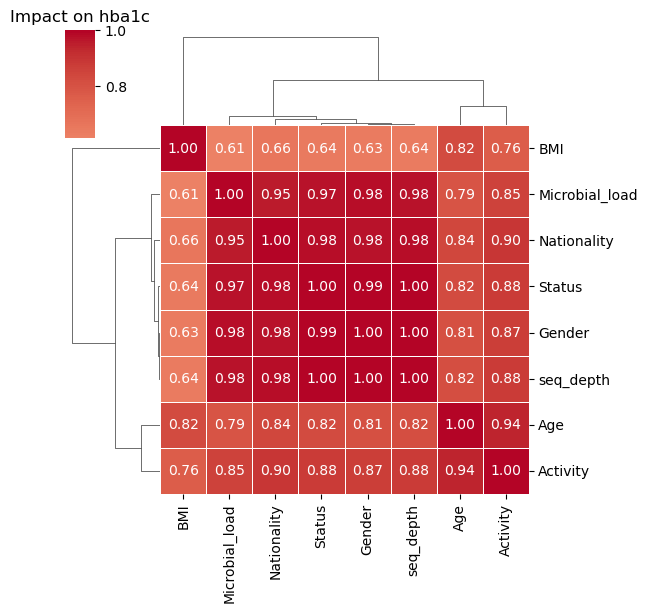

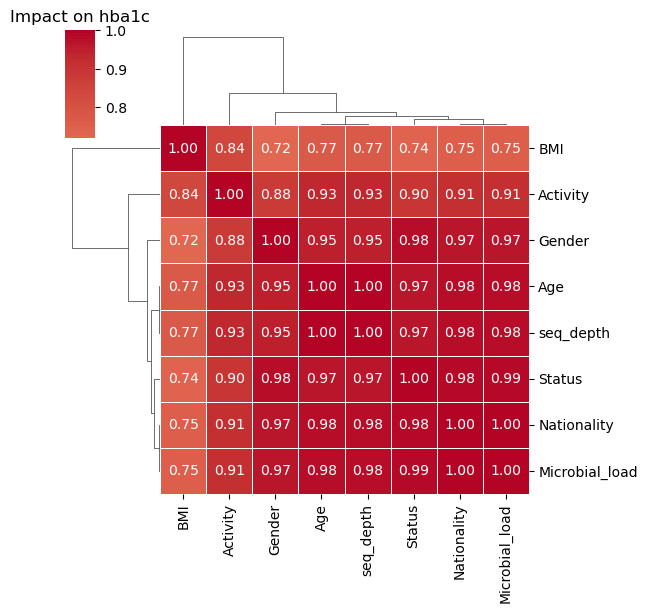

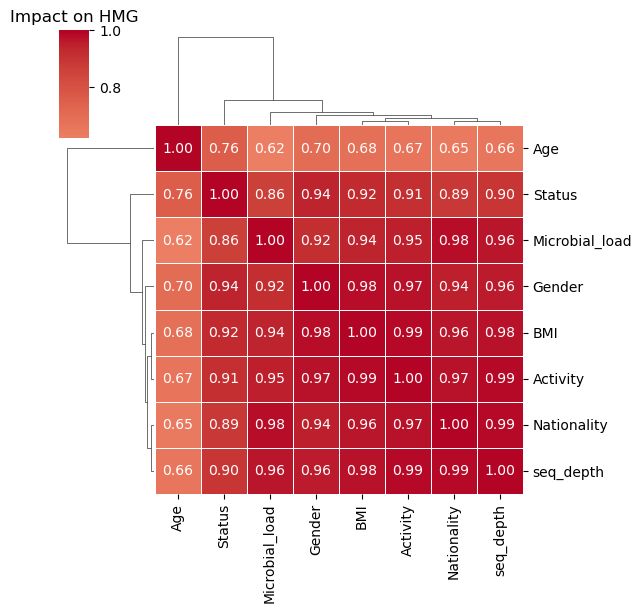

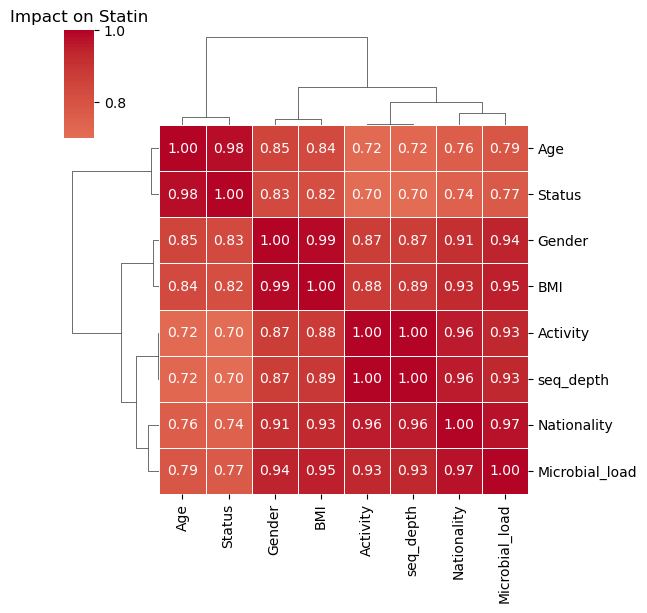

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, f_oneway

# Define dataset and variables
merged_df_microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# drop any nan values in hba1c
merged_df_microbes = merged_df_microbes.dropna(subset=['hba1c'])
df = merged_df_microbes.copy()
test_df = merged_df_microbes.copy()  # Use same dataset for now (split if needed)
# read statin_users.csv
statin_users = pd.read_csv("statin_microbes.csv")

covariates = ["C(Gender)", "Age", "BMI", "C(Nationality)", "C(Status)", "Activity", "seq_depth", "Microbial_load"]

# Define dependent variable 
dependent_var = 'hba1c'

plot_covariate_impact_clustermap(df, 'hba1c', covariates)

plot_covariate_impact_clustermap(statin_users, 'hba1c', covariates)

plot_covariate_impact_clustermap(df, 'HMG', covariates)

plot_covariate_impact_clustermap(df, 'Statin', covariates)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


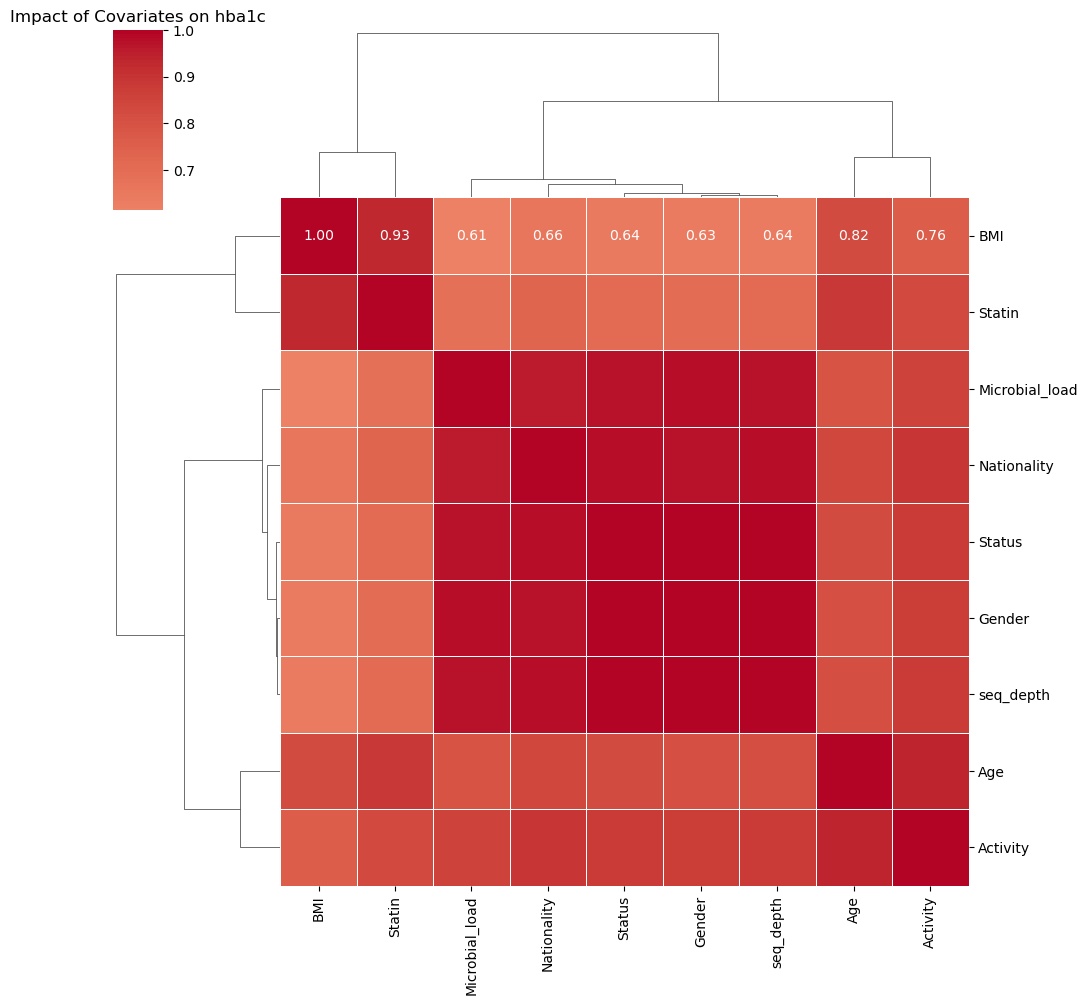

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


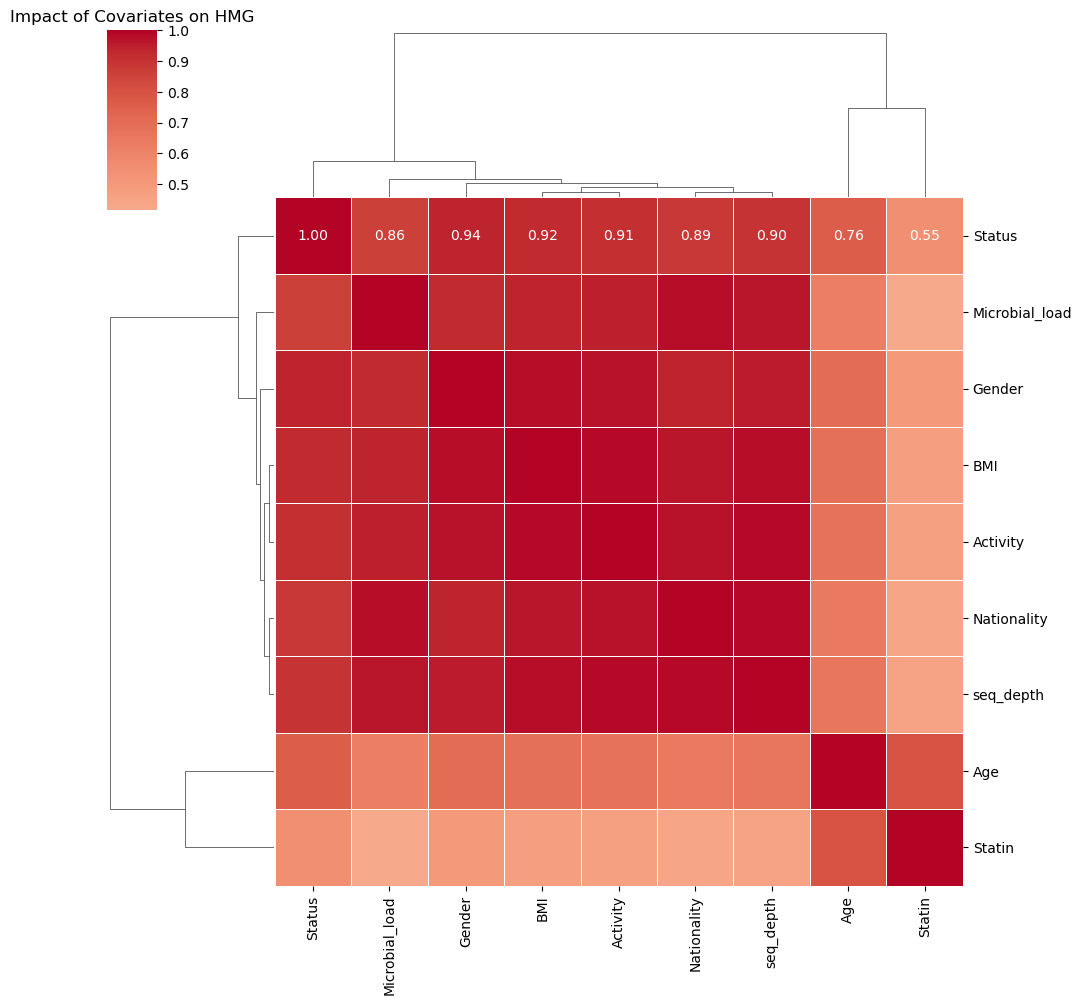

In [19]:
# Define dataset and variables
merged_df_microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# drop any nan values in hba1c
merged_df_microbes = merged_df_microbes.dropna(subset=['hba1c'])
df = merged_df_microbes.copy()
test_df = merged_df_microbes.copy()  # Use same dataset for now (split if needed)

covariates = ["C(Gender)", "Age", "BMI", "C(Nationality)", "C(Status)", "Activity", "seq_depth", "Microbial_load","Statin"]

# Define dependent variable 
dependent_var = 'hba1c'

plot_covariate_impact_clustermap(df, 'hba1c', covariates)

plot_covariate_impact_clustermap(df, 'HMG', covariates)

In [9]:
import pandas as pd
import numpy as np
from itertools import combinations
import statsmodels.api as sm
from statsmodels.formula.api import ols

def generate_results_df(df, dependent_var, independent_var, covariates, max_covariates=5):
    """
    Generates a DataFrame of regression results by testing different numbers of covariates.

    Args:
        df (pd.DataFrame): The dataset containing covariates, independent, and dependent variables.
        dependent_var (str): The dependent variable (e.g., 'hba1c').
        independent_var (str): The main independent variable.
        covariates (list): List of potential covariates to include.
        max_covariates (int): Maximum number of covariates to include in models (limits combinatorial explosion).

    Returns:
        pd.DataFrame: Results DataFrame containing num_covariates, R² values, AIC, BIC, etc.
    """
    # Extract actual column names (remove "C()" notation if present)
    covariates = [c[2:-1] if c.startswith("C(") and c.endswith(")") else c for c in covariates]

    # Ensure the dependent variable exists in df
    if dependent_var not in df.columns:
        raise KeyError(f"❌ Dependent variable '{dependent_var}' not found in DataFrame columns: {df.columns.tolist()}")

    # Ensure categorical variables are properly formatted
    categorical_vars = [cov for cov in covariates if df[cov].dtype == 'object' or df[cov].dtype.name == 'category']
    for cat in categorical_vars:
        df[cat] = df[cat].astype("category")

    results = []

    # Iterate through different numbers of covariates
    for r in range(0, min(len(covariates), max_covariates) + 1):
        for combo in combinations(covariates, r):

            # Construct formula
            covariate_terms = " + ".join(combo)
            formula = f"{dependent_var} ~ {independent_var} + {covariate_terms}" if combo else f"{dependent_var} ~ {independent_var}"

            # Fit model
            model = ols(formula, data=df).fit()

            # Store results
            results.append({
                'num_covariates': len(combo),
                'r2_train': model.rsquared,
                'adj_r2': model.rsquared_adj,
                'aic': model.aic,
                'bic': model.bic,
                'formula': formula
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [10]:
ind = 'escherichia_coli_cag00011'
#, 'unclassified_clostridiales_cag00013', 'eisenbergiella_tayi_cag00014', 'hungatella_hathewayi_2_cag00015', 'clostridium_sp__kle_1755___clostridiales_bacterium_ve202_27_cag00020', 'bacteroides_fragilis_1_cag00024', 'hungatella_hathewayi_1_cag00025', 'oscillibacter_sp__er4___firmicutes_bacterium_cag_129_59_24_cag01028', 'ruminococcus_sp__cag_177_cag00760', 'blautia_wexlerae_cag00164', 'clostridium_innocuum_cag00036', 'unclassified_clostridiales_cag00039', 'unclassified_gemmiger_cag00042', 'clostridium_symbiosum_cag00044', 'bacteroides_caccae_cag00049', 'bacteroides_thetaiotaomicron_cag00050', 'parabacteroides_goldsteinii_cag00052', 'roseburia_sp__cag_182_cag00055', 'ruminococcus_bromii_2_cag00611', 'coprococcus_eutactus_2_cag00490', 'unclassified_cag00064', 'gemmiger_formicilis_cag00601', 'firmicutes_bacterium_cag_176_cag00766', 'akkermansia_muciniphila_cag00301', 'eubacterium_siraeum_cag00653', 'oscillibacter_sp__57_20_cag01051', 'bacteroides_cellulosilyticus_cag00071', 'blautia_sp__cag_52___sp__2789stdy5834917_cag00112', 'clostridium_sp__cag_7_cag00079', 'bacteroides_massiliensis_cag00086', 'ruminococcus_sp__cag_17___blautia_sp__2789stdy5608880_cag00101', 'unclassified_lachnospiraceae_cag00102', 'clostridium_sp__cag_62_cag00580', 'bacteroides_nordii_cag00116', 'parabacteroides_merdae_cag00117', 'bacteroides_vulgatus_cag00118', 'bacteroides_finegoldii_cag00121', 'clostridium_sp__cag_58_cag00267', 'unclassified_clostridiales_cag00010_1', 'bifidobacterium_pseudocatenulatum_cag00342', 'bacteroides_eggerthii_cag00135', 'alistipes_shahii_cag00384', 'unclassified_cag00170', 'ruthenibacterium_lactatiformans_cag00140', 'parabacteroides_distasonis_cag00141', 'bacteroides_stercoris_cag00142', 'ruminococcus_torques_cag00243', 'bacteroides_uniformis_cag00159', 'unclassified_firmicutes_cag00160', 'unclassified_clostridiales_cag00854', 'clostridium_sp__cag_91___sp__2789stdy5834873_cag00563', 'bacteroides_clarus_cag00175', 'eubacterium_sp__cag_38_cag00178', 'blautia_sp__cag_237_cag00179', 'ruminococcus_sp__cag_60___blautia_sp__2789stdy5608836_cag00183', 'streptococcus_salivarius_cag00186', 'sutterella_wadsworthensis_1_cag00187', 'roseburia_sp__cag_100_cag00189', 'unclassified_cag00190', 'eubacterium_hallii_cag00194', 'unclassified_lachnospiraceae_cag50001', 'unclassified_gemmiger_cag00208', 'coprobacter_fastidiosus_cag00209', 'ruminococcus_bicirculans_cag00210', 'bilophila_wadsworthia_cag00212', 'barnesiella_intestinihominis_cag00218', 'unclassified_oscillibacter_cag00006_1', 'romboutsia_timonensis_cag00223', 'bacteroides_xylanisolvens_cag00945', 'eubacterium_sp__cag_248_cag00429', 'odoribacter_splanchnicus_cag00231', 'clostridium_saccharolyticum_2_cag00238', 'unclassified_clostridiales_cag00304', 'flavonifractor_plautii_cag00239', 'roseburia_sp__cag_197_cag00242', 'roseburia_sp__cag_45___sp__2789stdy5608886_cag00248', 'clostridium_leptum_cag00249', 'alistipes_inops____tidjanibacter_massiliensis_cag00251', 'ruminococcus_gnavus_cag00254', 'unclassified_clostridiales_cag00259', 'firmicutes_bacterium_cag_194_cag00265', 'firmicutes_bacterium_cag_24___clostridium_sp__2789stdy5834869___2789stdy5834922_cag00268', 'oscillibacter_sp__kle_1728___kle_1745___oscillospiraceae_ve202_24_cag00270', 'faecalibacterium_sp__cag_74_cag00272', 'fusicatenibacter_saccharivorans_cag00273', 'roseburia_faecis_cag00275', 'ruminococcus_sp__marseille_p328___blautia_sp__2789stdy5608844___sp__2789stdy5608844_cag00284', 'firmicutes_bacterium_cag_95_cag00288', 'roseburia_intestinalis_cag00291', 'firmicutes_bacterium_cag_145_cag00293', 'unclassified_clostridiales_cag00294', 'unclassified_faecalibacterium_cag00297', 'intestinimonas_butyriciproducens_cag00305', 'eubacterium_sp__cag_180_cag00523', 'azospirillum_sp__51_20_cag00302', 'unclassified_clostridium_cag00303', 'alistipes_onderdonkii_cag00309', 'clostridium_sp__cag_230_cag00317', 'phascolarctobacterium_sp__cag_207_cag00320', 'clostridium_sp__cag_138_cag00321', 'firmicutes_bacterium_cag_94_cag00324', 'unclassified_clostridiales_cag00327', 'alistipes_indistinctus_cag00328', 'roseburia_hominis_cag00329', 'anaerostipes_hadrus_1_cag00335', 'intestinibacter_bartlettii_cag00019_1', 'eubacterium_sp__cag_115_cag00341', 'bacteroides_ovatus_cag00357', 'alistipes_finegoldii_cag00360', 'coprococcus_comes_cag00366', 'firmicutes_bacterium_cag_170_cag00367', 'bacteroides_dorei_cag00371', 'unclassified_clostridiales_cag00373', 'unclassified_gemmiger_cag00568', 'unclassified_gemmiger_cag00492', 'eubacterium_sp__36_13___cag_86_cag00393', 'clostridium_sp__42_12___cag_75_cag00408', 'bacteroides_sp__cag_144_cag00413', 'lactobacillus_rogosae_cag00414', 'unclassified_eubacterium_cag00732', 'unclassified_cag00420', 'firmicutes_bacterium_cag_137_cag00424', 'paraprevotella_clara_cag00426', 'faecalibacterium_prausnitzii_7_cag00432', 'unclassified_flavonifractor_cag00439', 'unclassified_clostridium_cag00441', 'unclassified_clostridiales_cag00445', 'lachnospiraceae_bacterium_tf01_11___clostridium_sp__cag_122_cag00448', 'clostridium_sp__cag_253_cag00449', 'unclassified_firmicutes_cag00450', 'clostridium_sp__cag_167_cag00452', 'unclassified_clostridiales_cag00454', 'clostridium_sp__2789stdy5608884_cag00455', 'unclassified_clostridiales_cag00460', 'rhodospirillum_sp__unk_mgs_17___azospirillum_sp__47_25___cag_260_cag00461', 'faecalibacterium_sp__cag_82_cag00463', 'unclassified_clostridiales_cag00468', 'eubacterium_sp__38_16___cag_146_cag00469', 'unclassified_clostridiales_cag00470', 'sutterella_wadsworthensis_2_cag00474', 'unclassified_alistipes_cag00479', 'unclassified_blautia_cag00481', 'blautia_massiliensis_cag00482', 'unclassified_eggerthellaceae_cag00982', 'clostridium_sp__cag_127_cag00493', 'unclassified_firmicutes_cag00497', 'eubacterium_sp__cag_161_cag00502', 'unclassified_firmicutes_cag00505', 'clostridium_phoceensis_cag00506', 'alistipes_obesi_cag00508', 'unclassified_firmicutes_cag00509', 'unclassified_clostridiales_cag00513', 'eubacterium_eligens_cag00515', 'unclassified_clostridiales_cag00516', 'unclassified_firmicutes_cag00518', 'ruminococcus_sp__2789stdy5608794___sp__2789stdy5834890___firmicutes_bacterium_cag_56_cag00520', 'clostridia_bacterium_uc5_1_2e3_cag00519', 'methanobrevibacter_smithii_1_cag00721', 'unclassified_clostridiales_cag01700', 'dorea_sp__cag_105_cag00541', 'faecalibacterium_prausnitzii_5_cag00547', 'bifidobacterium_longum_cag00549', 'unclassified_clostridiales_cag00552', 'eubacterium_ramulus_cag00554', 'unclassified_clostridiales_cag00555', 'ruminococcus_callidus_cag00557', 'ruminococcus_lactaris_cag00558', 'unclassified_clostridiales_cag00559', 'unclassified_ruminococcaceae_cag00560', 'unclassified_clostridiales_cag50002', 'unclassified_blautia_cag00571', 'unclassified_clostridiales_cag00572', 'faecalibacterium_prausnitzii_3___l2_6__cag00577', 'alistipes_putredinis_cag00578', 'roseburia_inulinivorans_cag00582', 'unclassified_clostridiales_cag00596', 'alistipes_ihumii_cag00597', 'firmicutes_bacterium_cag_114_cag00603', 'firmicutes_bacterium_cag_110_cag00604', 'eubacterium_sp__cag_251___clostridium_sp__a254_mgs_251_cag00607', 'faecalibacterium_prausnitzii_1__a2_165__cag00612', 'unclassified_clostridiales_cag00618', 'faecalibacterium_prausnitzii_6_cag00619', 'blautia_obeum_cag00620', 'firmicutes_bacterium_cag_272_cag00621', 'unclassified_oscillibacter_cag00783', 'unclassified_gemmiger_cag00628', 'firmicutes_bacterium_cag_124_cag00629', 'unclassified_roseburia_cag00636', 'unclassified_clostridiales_cag00637', 'eubacterium_sp__cag_156_cag00639', 'unclassified_cag00643', 'christensenellaceae_bacterium_phil1___clostridium_sp__cag_226_cag00644', 'dorea_formicigenerans_cag00650', 'clostridium_sp__cag_43_cag00666', 'faecalibacterium_prausnitzii_4__cf__kle1255__cag00667', 'unclassified_clostridiales_cag00669', 'unclassified_firmicutes_cag00670', 'clostridium_sp__cag_169_cag00672', 'clostridium_sp__cag_217_cag00675', 'unclassified_firmicutes_cag00676', 'prevotella_copri_1_cag00686', 'unclassified_firmicutes_cag00692', 'clostridium_sp__cag_269_cag00983', 'unclassified_cag00696', 'unclassified_clostridiales_cag00697', 'bifidobacterium_adolescentis_cag00702', 'alistipes_senegalensis_cag00708', 'anaerostipes_hadrus_2_cag00713', 'eubacterium_ventriosum_cag00718', 'unclassified_clostridiales_cag00719', 'anaerotruncus_colihominis_cag00720', 'eggerthella_lenta_cag00727', 'ruminococcus_faecis_cag00736', 'dialister_invisus_cag00745', 'firmicutes_bacterium_cag_238_cag00751', 'unclassified_oscillibacter_cag00961', 'azospirillum_sp__cag_239_cag00753', 'unclassified_faecalibacterium_cag00755', 'coprobacter_secundus____gabonia_massiliensis_cag00756', 'candidatus_gastranaerophilales_bacterium_x14_cag00761', 'unclassified_lachnoclostridium_cag00764', 'firmicutes_bacterium_cag_176_63_11_cag00773', 'firmicutes_bacterium_cag_102_cag00775', 'firmicutes_bacterium_cag_65___clostridium_sp__2789stdy5608883_cag00792', 'firmicutes_bacterium_cag_41___clostridium_sp__2789stdy5834935___sp__2789stdy5608853_cag00780', 'eubacterium_rectale_cag00782', 'eubacterium_sp__cag_202_cag00796', 'dorea_longicatena_1_cag00799', 'faecalitalea_sp__uba637_cag00807', 'eubacterium_sp__cag_192_cag00814', 'coprobacillus_sp__8_1_38faa___clostridium_sp__2789stdy5608874_cag00818', 'unclassified_cag00824', 'unclassified_oscillibacter_cag00828', 'ruminococcus_sp__a254_mgs_254___cag_254_cag00830', 'unclassified_clostridiales_cag00831', 'unclassified_clostridiales_cag00849', 'unclassified_clostridiales_cag00851', 'clostridium_spiroforme_cag00852', 'streptococcus_thermophilus_cag00858', 'oscillibacter_sp__cag_241_cag00861', 'firmicutes_bacterium_cag_129_cag00862', 'unclassified_clostridiales_cag00863', 'unclassified_roseburia_cag00869', 'firmicutes_bacterium_cag_240_cag00872', 'butyricimonas_synergistica_2_cag00873', 'pseudoflavonifractor_sp__an184_cag00879', 'subdoligranulum_sp__cag_314_cag00880', 'unclassified_butyricicoccus_cag00893', 'unclassified_clostridiales_cag00895', 'firmicutes_bacterium_cag_83_cag00897', 'desulfovibrio_piger_cag00903', 'unclassified_intestinibacter_cag00908', 'parasutterella_excrementihominis_cag00909', 'unclassified_clostridiales_cag00919', 'unclassified_cag00928', 'unclassified_oscillibacter_cag00931', 'unclassified_firmicutes_cag00934', 'eggerthella_sp__51_9___cag_209_cag00936', 'lachnospira_sp__2789stdy5834967___clostridiales_bacterium_kle1615___41_12_two_minus_cag00937', 'firmicutes_bacterium_cag_313_cag00939', 'unclassified_firmicutes_cag00941', 'firmicutes_bacterium_cag_212___clostridium_sp__2789stdy5834871_cag00943', 'haemophilus_parainfluenzae_cag00950', 'clostridium_sp__cag_273_cag01094', 'unclassified_ruminococcaceae_cag00957', 'dorea_longicatena_2_cag00962', 'unclassified_firmicutes_cag00965', 'unclassified_firmicutes_cag00967', 'clostridium_sp__l2_50_cag00969', 'butyricicoccus_sp__n15_mgs_46___n54_mgs_46___k4410_mgs_46_cag00974', 'veillonella_atypica_cag00975', 'oscillibacter_sp__cag_241_62_21_cag00984', 'unclassified_clostridiales_cag00994', 'unclassified_firmicutes_cag00996', 'unclassified_clostridiales_cag01003', 'ruminococcus_sp__2789stdy5608817___eubacterium_sp__2789stdy5834872_cag01011', 'unclassified_clostridiales_cag01015', 'unclassified_clostridiales_cag01017', 'unclassified_gordonibacter_cag01019', 'ruminococcaceae_bacterium_d5_cag01020', 'unclassified_firmicutes_cag01024', 'clostridium_citroniae_cag01025', 'bacterium_lf_3___coprobacillus_sp__cag_235_cag01030', 'unclassified_coprococcus_cag01035', 'unclassified_faecalibacterium_cag01039', 'clostridium_asparagiforme____lavalense_cag01040', 'intestinimonas_massiliensis_cag01046', 'firmicutes_bacterium_cag_103_cag01052', 'firmicutes_bacterium_cag_65___clostridium_sp__2789stdy5608883_cag01637', 'haemophilus_parainfluenzae_cag01056', 'clostridium_sp__cag_245_cag01061', 'unclassified_clostridiales_cag01065', 'unclassified_firmicutes_cag01086', 'unclassified_firmicutes_cag01090', 'eggerthella_sp__cag_298_cag01115', 'clostridium_sp__2789stdy5834924_cag01132', 'senegalimassilia_anaerobia_cag01133', 'unclassified_oscillibacter_cag01146', 'blautia_sp__marseille_p3087___ruminococcus_sp__2789stdy5608882_cag01155', 'unclassified_lachnospiraceae_cag01156', 'veillonella_rogosae_cag01159', 'unclassified_roseburia_cag01162', 'bacteroides_ovatus_cag01165', 'unclassified_clostridiales_cag01169', 'unclassified_clostridiales_cag01183', 'firmicutes_bacterium_cag_321_cag01188', 'butyricimonas_virosa_cag01190', 'allisonella_histaminiformans_cag01197', 'bacteroides_cellulosilyticus_cag01202', 'phascolarctobacterium_succinatutens_cag01205', 'unclassified_oscillibacter_cag01207', 'coprococcus_catus_cag01208', 'unclassified_lachnospiraceae_cag01214', 'unclassified_clostridiales_cag01215', 'phascolarctobacterium_succinatutens_cag01220', 'blautia_sp__marseille_p3087___ruminococcus_sp__2789stdy5608882_cag01222', 'unclassified_firmicutes_cag01223', 'unclassified_firmicutes_cag01225', 'unclassified_lachnoclostridium_cag01228', 'unclassified_blautia_cag01235', 'unclassified_oscillibacter_cag01237', 'butyrate_producing_bacterium_ss3_4___clostridium_sp__cag_81_cag01238', 'blautia_sp__2789stdy5608796___sp__2789stdy5608848_cag01239', 'unclassified_clostridiales_cag01245', 'eubacterium_sp__cag_274_cag01253', 'clostridium_bolteae_cag01263', 'adlercreutzia_equolifaciens_cag01272', 'unclassified_clostridiales_cag01281', 'clostridium_sp__2789stdy5834874___sp__2789stdy5608885_cag50003', 'unclassified_clostridiales_cag01299', 'blautia_sp__marseille_p3087___ruminococcus_sp__2789stdy5608882_cag01301', 'lachnoclostridium_sp__an138_cag01302', 'unclassified_firmicutes_cag01308', 'clostridium_bolteae_cag01320', 'faecalibacterium_prausnitzii_2_cag01321', 'parabacteroides_merdae_cag01323', 'unclassified_clostridiales_cag01325', 'clostridium_sp__2789stdy5608793_cag02021', 'butyricimonas_virosa_cag01356', 'eisenbergiella_tayi_cag01358', 'clostridium_sp__cag_221_cag01359', 'streptococcus_parasanguinis_cag01366', 'roseburia_intestinalis_cag01369', 'escherichia_coli_cag01371', 'unclassified_oscillibacter_cag01372', 'hungatella_hathewayi_2_cag01379', 'flavonifractor_sp__2789stdy5834895___sp__2789stdy5834937____clostridium_sp__2789stdy5608878_cag01380', 'blautia_massiliensis_cag01386', 'unclassified_oscillibacter_cag01399', 'turicibacter_sanguinis_2_cag01402', 'butyricimonas_synergistica_2_cag01408', 'unclassified_oscillibacter_cag01551']

results_df = generate_results_df(df, dependent_var='hba1c',independent_var=ind, covariates=covariates)



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_covariate_effect(results_df, dependent_var):
    """
    Plots the number of covariates used in regression vs. the explanatory power (R²) for the dependent variable.

    Args:
        results_df (pd.DataFrame): DataFrame containing model results (must include 'num_covariates' and R² values).
        dependent_var (str): Name of the dependent variable (for plot title).
    
    Returns:
        None: Displays the plot.
    """

    if results_df.empty:
        print(" No results to plot!")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with regression trend
    
    sns.scatterplot(x='num_covariates', y='r2_train', data=results_df, label="Train R²", color="red")
    sns.lineplot(x='num_covariates', y='r2_train', data=results_df, color="red", alpha=0.6)

    # Plot Formatting
    plt.xlabel("Number of Covariates")
    plt.ylabel("R² Value")
    plt.title(f"Effect of Covariate Count on {dependent_var} Prediction")
    plt.legend()
    plt.grid(True)

    plt.show()


/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


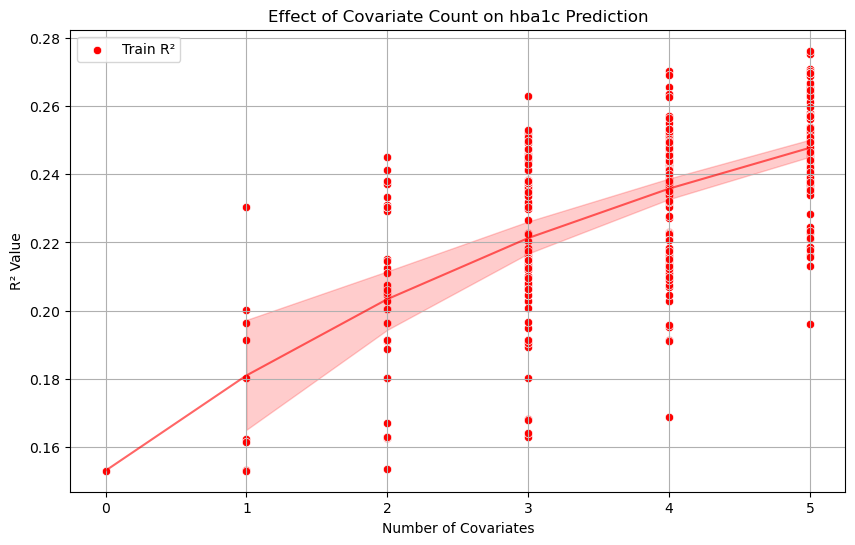

In [17]:


plot_covariate_effect(results_df, 'hba1c')
